# Installs & Imports

In [1]:
!pip install -q einops
!pip install -q local-attention
!pip install -q matplotlib
!pip install -q plotly
!pip install -q numpy
!pip install -q pandas
!pip install -q scikit-learn
!pip install -q scipy
!pip install -q sktime
!pip install -q sympy
!pip install -q torch
!pip install -q tqdm
!pip install -q dask[dataframe]
!pip install -q triton
!pip install -q mamba-ssm
!pip install -q yfinance
!pip install -q optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.8/36.8 MB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.5/141.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 20.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.8 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

import math
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from mamba_ssm import Mamba
import yfinance as yf
import optuna

# Data Loading

In [3]:
def load_data():
    """
    Load a time series dataset using yfinance. Fetch daily AAPL closing prices
    from 2010-01-01 to 2020-01-01. Ensure the dataframe has:
    - A DatetimeIndex
    - A single 'Value' column containing the closing prices

    Returns
    -------
    df : pd.DataFrame
        DataFrame with a DatetimeIndex and a 'Value' column.
    """
    df = yf.download('AAPL', start='2010-01-01', end='2020-01-01', progress=False)
    df = pd.DataFrame(df['Close'].values, index=df.index, columns=['Value'])
    return df

# Load the dataset
df = load_data()
display(df.head(30))
print(f"\nDataset length: {len(df)}")

,Value
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714
2010-01-11,7.503929
2010-01-12,7.418571
2010-01-13,7.523214
2010-01-14,7.479643



Dataset length: 2516


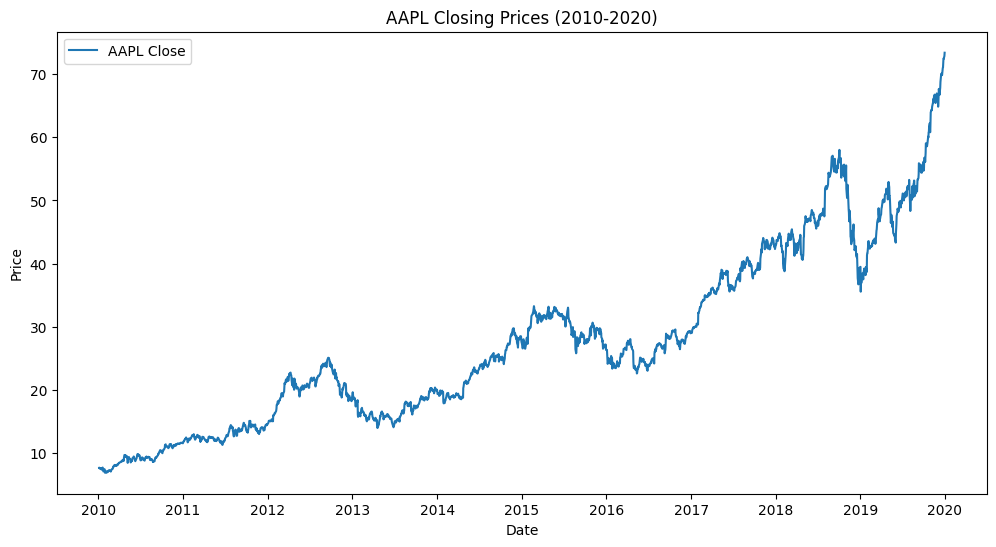

Dataset length: 2516 data points


In [4]:
def visualize_data(df):
    """
    Plot the time series to visualize its behavior.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Value'], label='AAPL Close')
    plt.title('AAPL Closing Prices (2010-2020)')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    print(f"Dataset length: {len(df)} data points")

# Visualize the time series
visualize_data(df)

# Data Exploration

In [5]:
# Summary statistics
print("Summary Statistics:")
display(df.describe())

Summary Statistics:


,Value
count,2516.000000
mean,27.586323
std,14.043239
min,6.858929
25%,16.178571
50%,24.870000
75%,37.638125
max,73.412498


In [6]:
def check_stationarity(timeseries, column_name='Value', cutoff=0.01):
    """
    Perform the Augmented Dickey-Fuller test to check for stationarity of a time series.

    Parameters
    ----------
    timeseries : pd.DataFrame or pd.Series
        The time series data. If a DataFrame is provided, 'column_name' must exist in it.
    column_name : str
        The name of the column containing the time series values if a DataFrame is given.
    cutoff : float
        p-value cutoff for determining stationarity. If p-value < cutoff, consider series stationary.

    Returns
    -------
    dfoutput : pd.Series
        Series containing ADF test results.
    stationary : bool
        True if the series is considered stationary, False otherwise.
    """
    if isinstance(timeseries, pd.DataFrame):
        if column_name not in timeseries.columns:
            raise ValueError(f"Column '{column_name}' not found in the dataframe.")
        series = timeseries[column_name]
    else:
        series = timeseries

    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series({
        'Test Statistic': dftest[0],
        'p-value': dftest[1],
        '# Lags Used': dftest[2],
        'Number of Observations Used': dftest[3],
        'Critical Value (1%)': dftest[4]['1%'],
        'Critical Value (5%)': dftest[4]['5%'],
        'Critical Value (10%)': dftest[4]['10%']
    }, name='ADF Test Results')

    stationary = dfoutput['p-value'] < cutoff
    return dfoutput, stationary

In [7]:
# Run stationarity check
adf_results, is_stationary = check_stationarity(df, column_name='Value')
display(adf_results)
print("Is stationary?", is_stationary)

,ADF Test Results
Test Statistic,1.444835
p-value,0.997309
# Lags Used,9.000000
Number of Observations Used,2506.000000
Critical Value (1%),-3.432962
Critical Value (5%),-2.862694
Critical Value (10%),-2.567384


Is stationary? False


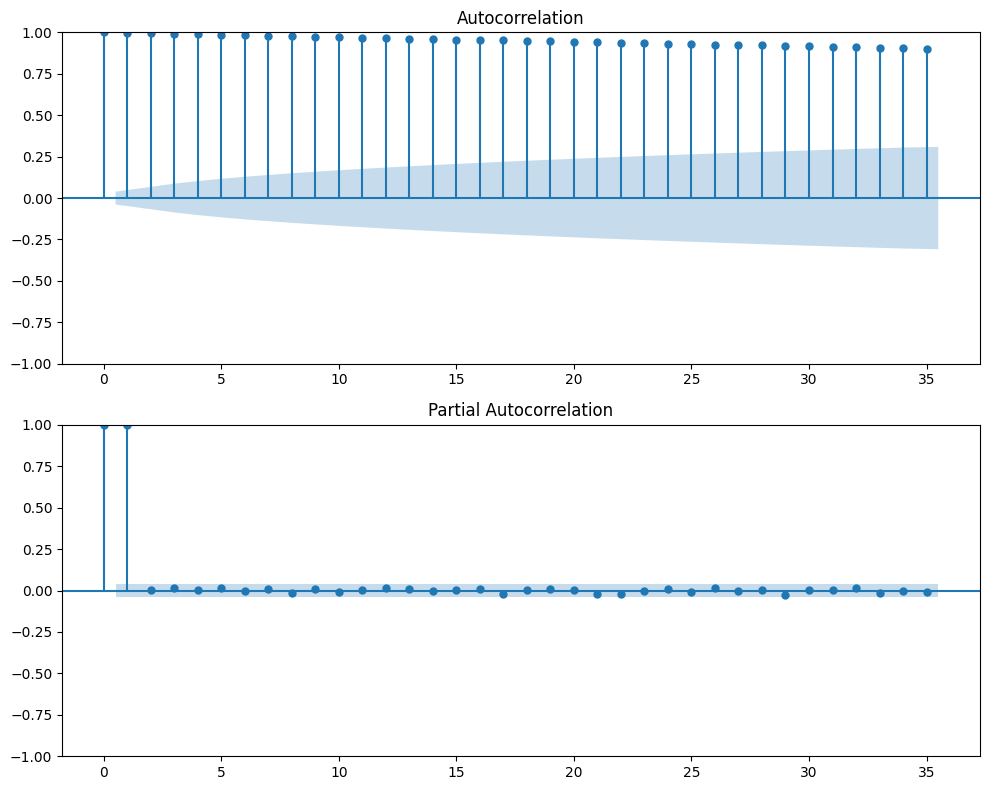

In [8]:
# Autocorrelation and Partial Autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
plot_acf(df['Value'], ax=ax[0])
ax[0].set_title('Autocorrelation')
plot_pacf(df['Value'], ax=ax[1])
ax[1].set_title('Partial Autocorrelation')
plt.tight_layout()
plt.show()

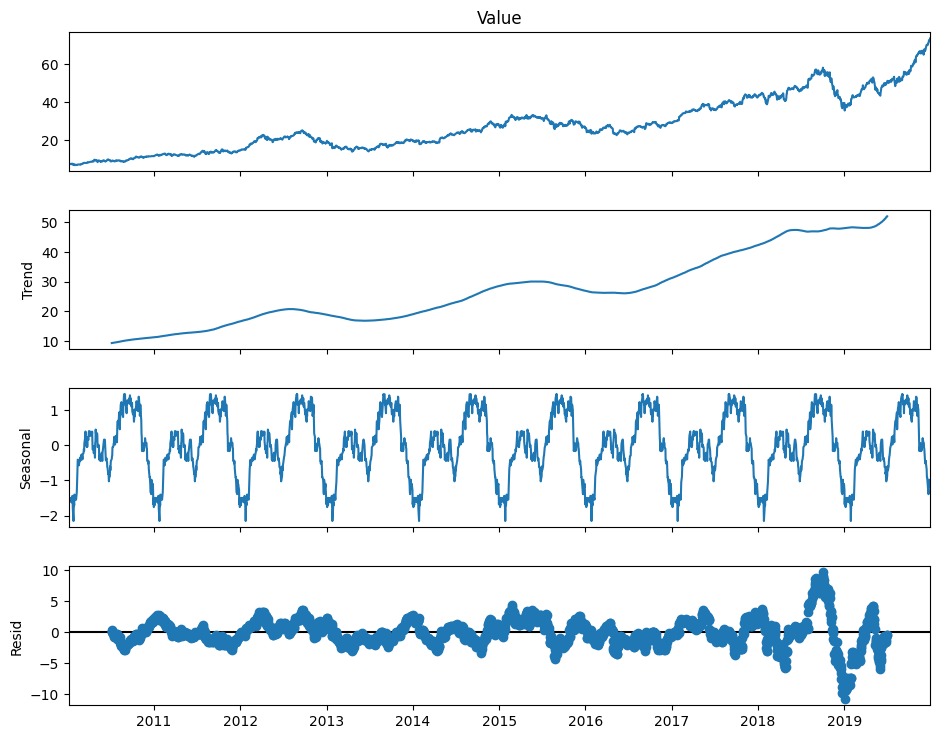

In [9]:
# Decompose the series to check seasonality
try:
    decomposition = seasonal_decompose(df['Value'], model='additive', period=252)
    fig = decomposition.plot()
    fig.set_size_inches(10, 8)
    plt.show()
except:
    print("Decomposition failed, possibly due to data frequency or chosen period.")

# Feature Engineering

In [10]:
def create_time_features(index):
    """
    Create time features from a DatetimeIndex.
    For daily data, we'll consider: [month, day, weekday, dayofyear]

    Parameters
    ----------
    index : pd.DatetimeIndex
        Index of dates.

    Returns
    -------
    features : np.ndarray
        Time features array of shape [len(index),4].
    """
    month = index.month.values
    day = index.day.values
    weekday = index.weekday.values
    day_of_year = index.dayofyear.values
    features = np.stack([month, day, weekday, day_of_year], axis=1)
    return features

In [11]:
# Create time-based features
full_time_features = create_time_features(df.index)
print(f"Time features shape: {full_time_features.shape}")
print(full_time_features[:5])

Time features shape: (2516, 4)
[[1 4 0 4]
 [1 5 1 5]
 [1 6 2 6]
 [1 7 3 7]
 [1 8 4 8]]


# Data Splitting

In [12]:
def split_data(df, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split the data into train, validation, and test sets by index.

    Parameters
    ----------
    df : pd.DataFrame or pd.Series
        Time series data.
    train_ratio : float
        Proportion of data for training.
    val_ratio : float
        Proportion of data for validation.
    test_ratio : float
        Proportion of data for testing.

    Returns
    -------
    train_idx, val_idx, test_idx : array-like
        Indices for train, val, and test splits.
    """
    n = len(df)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    train_idx = np.arange(0, train_end)
    val_idx = np.arange(train_end, val_end)
    test_idx = np.arange(val_end, n)
    return train_idx, val_idx, test_idx

In [13]:
# Split the dataset
train_idx, val_idx, test_idx = split_data(df)

print(f"Train set length: {len(train_idx)}")
print(f"Validation set length: {len(val_idx)}")
print(f"Test set length: {len(test_idx)}")

Train set length: 1761
Validation set length: 377
Test set length: 378


In [14]:
def plot_train_val_test_split(df, train_idx, val_idx, test_idx):
    """
    Plot the train, validation, and test splits of a time series.

    Parameters
    ----------
    df : pd.Series
        The complete time series.
    train_idx : array-like
        Indices for training data.
    val_idx : array-like
        Indices for validation data.
    test_idx : array-like
        Indices for test data.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[train_idx], df.values[train_idx], label='Train', color='blue')
    plt.plot(df.index[val_idx], df.values[val_idx], label='Validation', color='orange')
    plt.plot(df.index[test_idx], df.values[test_idx], label='Test', color='green')

    # Mark the splits with vertical dotted lines
    if len(val_idx) > 0:
        plt.axvline(df.index[val_idx[0]], color='black', linestyle='dotted', linewidth=2)
    if len(test_idx) > 0:
        plt.axvline(df.index[test_idx[0]], color='black', linestyle='dotted', linewidth=2)

    plt.title('Train / Validation / Test Split')
    plt.legend()
    plt.show()

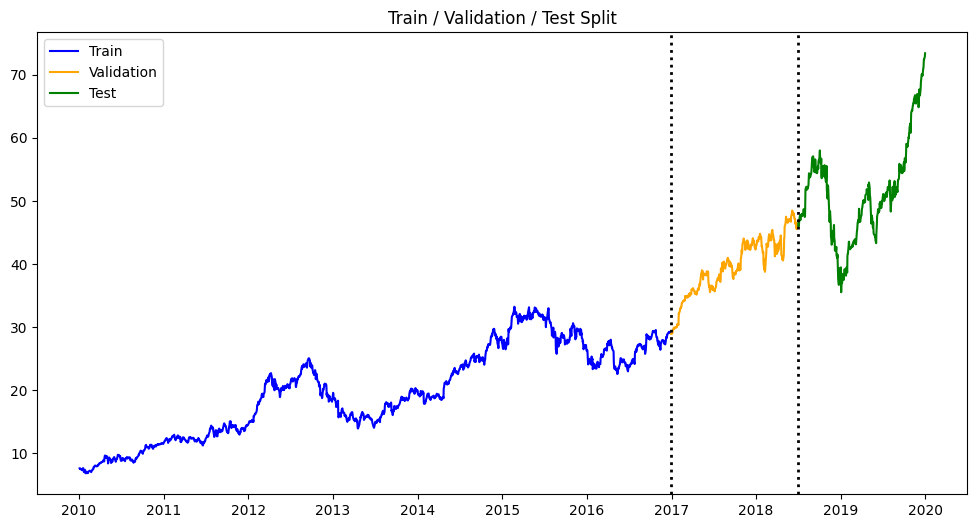

In [15]:
# Plot the split
plot_train_val_test_split(df['Value'], train_idx, val_idx, test_idx)

# Data Preparation

In [16]:
def manual_scale(train_data, val_data, test_data, epsilon=1e-10):
    """
    Manually scale the data using mean and std of the training set.

    Parameters
    ----------
    train_data : np.ndarray
        Training data (1D array of values).
    val_data : np.ndarray
        Validation data (1D array of values).
    test_data : np.ndarray
        Test data (1D array of values).
    epsilon : float
        Small value to avoid division by zero.

    Returns
    -------
    train_scaled : np.ndarray
        Scaled training data.
    val_scaled : np.ndarray
        Scaled validation data.
    test_scaled : np.ndarray
        Scaled test data.
    mean_ : float
        Mean of the training data.
    std_ : float
        Std of the training data.
    """
    mean_ = np.mean(train_data)
    std_ = np.std(train_data)
    train_scaled = (train_data - mean_) / (std_ + epsilon)
    val_scaled = (val_data - mean_) / (std_ + epsilon)
    test_scaled = (test_data - mean_) / (std_ + epsilon)
    return train_scaled, val_scaled, test_scaled, mean_, std_

In [17]:
def create_sequences(values, time_features, input_length, output_length):
    """
    Create sequences (X, Y) and their corresponding time features (X_mark, Y_mark) from the given arrays.

    Parameters
    ----------
    values : np.ndarray
        1D array of values.
    time_features : np.ndarray
        2D array of time features of shape (N,4).
    input_length : int
        Number of past points to use as input.
    output_length : int
        Number of future points to predict.

    Returns
    -------
    X : np.ndarray
        Input sequences of shape (num_samples, input_length).
    Y : np.ndarray
        Output sequences of shape (num_samples, output_length).
    X_mark : np.ndarray
        Time features corresponding to input sequences (num_samples, input_length, 4).
    Y_mark : np.ndarray
        Time features corresponding to output sequences (num_samples, output_length, 4).
    """
    N = len(values)
    samples = N - input_length - output_length + 1
    X = []
    Y = []
    X_mark = []
    Y_mark = []
    for i in range(samples):
        X.append(values[i:i+input_length])
        Y.append(values[i+input_length:i+input_length+output_length])
        X_mark.append(time_features[i:i+input_length])
        Y_mark.append(time_features[i+input_length:i+input_length+output_length])

    X = np.array(X)
    Y = np.array(Y)
    X_mark = np.array(X_mark)
    Y_mark = np.array(Y_mark)
    return X, Y, X_mark, Y_mark

In [18]:
class TimeSeriesDataset(Dataset):
    """
    PyTorch Dataset for time series forecasting.
    Provides:
    x : past values [input_length]
    y : future values [output_length]
    x_mark : temporal features for x
    y_mark : temporal features for y
    """
    def __init__(self, X, Y, X_mark, Y_mark):
        """
        Parameters
        ----------
        X : np.ndarray
            Input sequences (N, input_length).
        Y : np.ndarray
            Output sequences (N, output_length).
        X_mark : np.ndarray
            Time features for input sequences (N, input_length, 4).
        Y_mark : np.ndarray
            Time features for output sequences (N, output_length, 4).
        """
        self.X = X
        self.Y = Y
        self.X_mark = X_mark
        self.Y_mark = Y_mark

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(-1)
        y = torch.tensor(self.Y[idx], dtype=torch.float32).unsqueeze(-1)
        x_mark = torch.tensor(self.X_mark[idx], dtype=torch.float32)
        y_mark = torch.tensor(self.Y_mark[idx], dtype=torch.float32)
        return x, y, x_mark, y_mark

In [19]:
def prepare_data_workflow(df,
                          time_features,
                          input_length=60,
                          output_length=1,
                          train_ratio=0.7,
                          val_ratio=0.15,
                          test_ratio=0.15,
                          overlapping=False):
    """
    Prepare the data for training, validation, and testing according to the user choice of overlapping or not.

    Steps:
    - If overlapping = False (default):
        1) Split data first
        2) Scale using train stats
        3) Create sequences from each split separately
    - If overlapping = True:
        1) Create sequences from entire dataset
        2) Split the sequences
        3) Scale the splitted sequences using train stats

    Parameters
    ----------
    df : pd.DataFrame
        Original dataframe with 'Value' column.
    time_features : np.ndarray
        Time features array of shape [N,3].
    input_length : int
        Length of input sequence.
    output_length : int
        Length of output sequence.
    train_ratio : float
        Proportion of data for training.
    val_ratio : float
        Proportion of data for validation.
    test_ratio : float
        Proportion of data for testing.
    overlapping : bool
        If True, create overlapping sequences before splitting.
        If False, split first then create sequences.

    Returns
    -------
    train_loader : DataLoader
        DataLoader for training set.
    val_loader : DataLoader
        DataLoader for validation set.
    test_loader : DataLoader
        DataLoader for test set.
    mean_ : float
        Mean of the training data (for inverse scaling).
    std_ : float
        Std of the training data (for inverse scaling).
    """
    values = df['Value'].values
    N = len(values)

    # Get indices for splitting
    train_idx, val_idx, test_idx = split_data(df, train_ratio, val_ratio, test_ratio)
    print(f"Train indices length: {len(train_idx)}, Val: {len(val_idx)}, Test: {len(test_idx)}")

    # Plot again to confirm splits visually
    plot_train_val_test_split(df['Value'], train_idx, val_idx, test_idx)

    if not overlapping:
        print("\nUsing non-overlapping approach...")
        # Non-overlapping: Split -> Scale -> Sequence
        train_values = values[train_idx]
        val_values = values[val_idx]
        test_values = values[test_idx]

        train_tf = time_features[train_idx]
        val_tf = time_features[val_idx]
        test_tf = time_features[test_idx]

        # Scale based on training set only
        train_scaled, val_scaled, test_scaled, mean_, std_ = manual_scale(train_values, val_values, test_values)

        print(f"Train mean: {mean_}, Train std: {std_}")
        print(f"Train scaled shape: {train_scaled.shape}, Val scaled: {val_scaled.shape}, Test scaled: {test_scaled.shape}")

        # Create sequences separately
        X_train, Y_train, X_mark_train, Y_mark_train = create_sequences(train_scaled, train_tf, input_length, output_length)
        X_val, Y_val, X_mark_val, Y_mark_val = create_sequences(val_scaled, val_tf, input_length, output_length)
        X_test, Y_test, X_mark_test, Y_mark_test = create_sequences(test_scaled, test_tf, input_length, output_length)

    else:
        print("\nUsing overlapping approach...")
        # Overlapping: Sequence -> Split -> Scale
        # Create sequences from entire dataset first
        X_all, Y_all, X_mark_all, Y_mark_all = create_sequences(values, time_features, input_length, output_length)

        total_samples = len(X_all)
        seq_train_end = int(total_samples * train_ratio)
        seq_val_end = seq_train_end + int(total_samples * val_ratio)

        X_train = X_all[:seq_train_end]
        Y_train = Y_all[:seq_train_end]
        X_mark_train = X_mark_all[:seq_train_end]
        Y_mark_train = Y_mark_all[:seq_train_end]

        X_val = X_all[seq_train_end:seq_val_end]
        Y_val = Y_all[seq_train_end:seq_val_end]
        X_mark_val = X_mark_all[seq_train_end:seq_val_end]
        Y_mark_val = Y_mark_all[seq_train_end:seq_val_end]

        X_test = X_all[seq_val_end:]
        Y_test = Y_all[seq_val_end:]
        X_mark_test = X_mark_all[seq_val_end:]
        Y_mark_test = Y_mark_all[seq_val_end:]

        # Compute scaling stats from training sequences
        train_data_for_stats_all = np.concatenate([X_train.flatten(), Y_train.flatten()])
        mean_, std_ = np.mean(train_data_for_stats_all), np.std(train_data_for_stats_all)

        def scale_set(X, Y):
            X = (X - mean_) / (std_ + 1e-8)
            Y = (Y - mean_) / (std_ + 1e-8)
            return X, Y

        X_train, Y_train = scale_set(X_train, Y_train)
        X_val, Y_val = scale_set(X_val, Y_val)
        X_test, Y_test = scale_set(X_test, Y_test)

        print(f"\nTrain mean: {mean_}, Train std: {std_}")
        print("Shapes after split and scale:")
        print(f"X_train: {X_train.shape}, Y_train: {Y_train.shape}")
        print(f"X_val: {X_val.shape}, Y_val: {Y_val.shape}")
        print(f"X_test: {X_test.shape}, Y_test: {Y_test.shape}")

    # Create Datasets
    train_dataset = TimeSeriesDataset(X_train, Y_train, X_mark_train, Y_mark_train)
    val_dataset = TimeSeriesDataset(X_val, Y_val, X_mark_val, Y_mark_val)
    test_dataset = TimeSeriesDataset(X_test, Y_test, X_mark_test, Y_mark_test)

    print("\nTrain Dataset length:", len(train_dataset))
    print("Val Dataset length:", len(val_dataset))
    print("Test Dataset length:", len(test_dataset))

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    print(f"\nTrain loader batches: {len(train_loader)}")
    print(f"Val loader batches: {len(val_loader)}")
    print(f"Test loader batches: {len(test_loader)}")

    return train_loader, val_loader, test_loader, mean_, std_

Train indices length: 1761, Val: 377, Test: 378


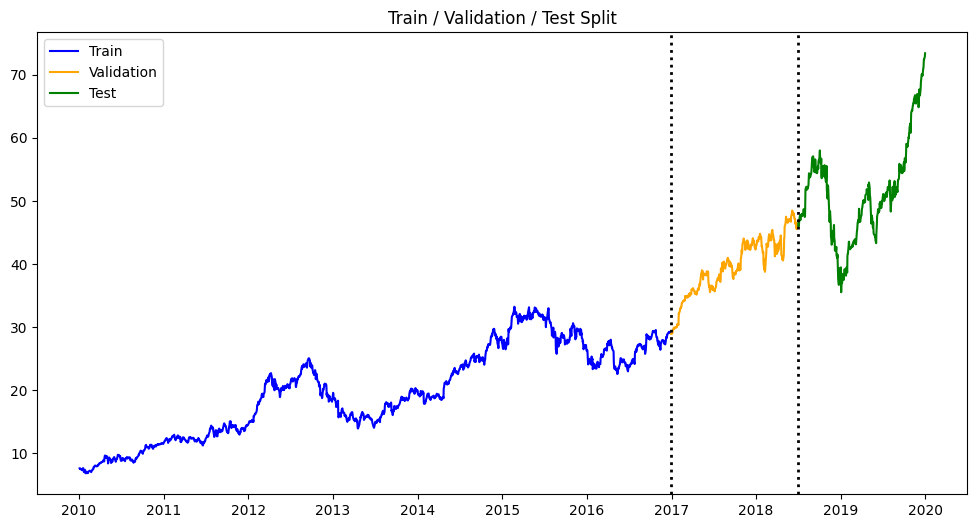


Using non-overlapping approach...
Train mean: 19.845500734297815, Train std: 7.079373036317053
Train scaled shape: (1761,), Val scaled: (377,), Test scaled: (378,)

Train Dataset length: 1701
Val Dataset length: 317
Test Dataset length: 318

Train loader batches: 54
Val loader batches: 10
Test loader batches: 10


In [20]:
# Prepare the data
train_loader, val_loader, test_loader, mean_, std_ = prepare_data_workflow(
    df,
    full_time_features,
    input_length=60,
    output_length=1,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    overlapping=False
)

# Model Definition

In [21]:
class PositionalEmbedding(nn.Module):
    """
    Positional embedding using sine/cosine patterns.
    """
    def __init__(self, d_model, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False
        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0)/d_model)).exp()
        pe[:,0::2] = torch.sin(position*div_term)
        pe[:,1::2] = torch.cos(position*div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: [B,L,...]
        return self.pe[:, :x.size(1)]

class TokenEmbedding(nn.Module):
    """
    Embedding for the value tokens using a 1D convolution.
    """
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Conv1d(in_channels=c_in, out_channels=d_model,
                                   kernel_size=3, padding=1, padding_mode='circular', bias=False)
        nn.init.kaiming_normal_(self.tokenConv.weight, mode='fan_in', nonlinearity='leaky_relu')

    def forward(self, x):
        # x: [B,L,C_in]
        x = self.tokenConv(x.permute(0,2,1)).transpose(1,2)
        return x

class FixedEmbedding(nn.Module):
    """
    Fixed embedding for encoding categorical attributes like month, day, weekday.
    """
    def __init__(self, c_in, d_model):
        super(FixedEmbedding, self).__init__()
        w = torch.zeros(c_in, d_model).float()
        w.require_grad = False

        position = torch.arange(0,c_in).float().unsqueeze(1)
        div_term = (torch.arange(0,d_model,2).float()*-(math.log(10000.0)/d_model)).exp()

        w[:,0::2] = torch.sin(position*div_term)
        w[:,1::2] = torch.cos(position*div_term)

        self.emb = nn.Embedding(c_in,d_model)
        self.emb.weight = nn.Parameter(w, requires_grad=False)

    def forward(self,x):
        return self.emb(x).detach()

class TemporalEmbedding(nn.Module):
    """
    Temporal embedding for [month, day, weekday, day_of_year]
    """
    def __init__(self, d_model, embed_type='fixed'):
        super(TemporalEmbedding, self).__init__()
        month_size = 13
        day_size = 32
        weekday_size = 7
        day_of_year_size = 367  # accounting for leap years
        Embed = FixedEmbedding if embed_type=='fixed' else nn.Embedding

        self.month_embed = Embed(month_size, d_model)
        self.day_embed = Embed(day_size, d_model)
        self.weekday_embed = Embed(weekday_size, d_model)
        self.day_of_year_embed = Embed(day_of_year_size, d_model)

    def forward(self,x):
        # x: [B,L,4] = [month, day, weekday, day_of_year]
        x = x.long()
        month_x = self.month_embed(x[:,:,0])
        day_x = self.day_embed(x[:,:,1])
        weekday_x = self.weekday_embed(x[:,:,2])
        day_of_year_x = self.day_of_year_embed(x[:,:,3])
        return month_x + day_x + weekday_x + day_of_year_x

class DataEmbedding(nn.Module):
    """
    Combines value embeddings, positional embeddings, and temporal embeddings.
    """
    def __init__(self, c_in, d_model, embed_type='fixed', dropout=0.1):
        super(DataEmbedding, self).__init__()
        self.value_embedding = TokenEmbedding(c_in=c_in, d_model=d_model)
        self.position_embedding = PositionalEmbedding(d_model=d_model)
        self.temporal_embedding = TemporalEmbedding(d_model=d_model, embed_type=embed_type)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, x_mark):
        # x: [B,L,1]
        # x_mark: [B,L,4]
        x = self.value_embedding(x) + self.temporal_embedding(x_mark) + self.position_embedding(x)
        return self.dropout(x)

In [22]:
class MambaModel(nn.Module):
    """
    MambaModel using the Mamba state-space layer and DataEmbedding.
    """
    def __init__(self, d_model=128, d_ff=16, d_conv=4, expand=2, output_dim=1, embed_type='fixed', dropout=0.1):
        """
        Parameters
        ----------
        d_model : int
            Dimension of the model.
        d_ff : int
            Dimension of the state (feedforward) inside Mamba.
        d_conv : int
            Dimension of the convolution channel inside Mamba.
        expand : int
            Expansion factor for internal layers.
        output_dim : int
            Output dimension (e.g., 1 for univariate).
        embed_type : str
            Embedding type (e.g., 'fixed').
        dropout : float
            Dropout rate.
        """
        super(MambaModel, self).__init__()
        self.embedding = DataEmbedding(c_in=1, d_model=d_model, embed_type=embed_type, dropout=dropout)

        self.mamba = Mamba(
            d_model=d_model,
            d_state=d_ff,
            d_conv=d_conv,
            expand=expand
        )

        self.out_layer = nn.Linear(d_model, output_dim, bias=False)

    def forward(self, x, x_mark):
        # x: [B,L,1], x_mark: [B,L,4]
        x_emb = self.embedding(x, x_mark) # [B,L,d_model]
        x_out = self.mamba(x_emb) # [B,L,d_model]
        x_out = self.out_layer(x_out) # [B,L,1]
        return x_out

In [23]:
class SMAPELoss(nn.Module):
    """
    Symmetric Mean Absolute Percentage Error (sMAPE) Loss.
    """
    def __init__(self, eps=1e-5):
        super(SMAPELoss, self).__init__()
        self.eps = eps

    def forward(self, pred, target):
        """
        Parameters
        ----------
        pred : torch.Tensor
            Predicted values of shape [B,L,1].
        target : torch.Tensor
            True values of shape [B,L,1].

        Returns
        -------
        loss : torch.Tensor
            sMAPE loss (scalar).
        """
        numerator = torch.abs(pred - target)
        denominator = (torch.abs(pred) + torch.abs(target) + self.eps)
        smape = 2.0 * numerator / denominator
        return torch.mean(smape) * 100

In [24]:
# Initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MambaModel(
    d_model=64,
    d_ff=128,
    d_conv=32,
    expand=4,
    output_dim=1,
    embed_type='fixed',
    dropout=0.1
).to(device)

# Initialize optimizer and loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
smape_criterion = SMAPELoss()

# Print model configuration
print(f"Device: {device}")
print(f"Model: {model}")
print(f"Optimizer: {optimizer}")
print(f"Loss function: {smape_criterion}")

Device: cuda
Model: MambaModel(
  (embedding): DataEmbedding(
    (value_embedding): TokenEmbedding(
      (tokenConv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False, padding_mode=circular)
    )
    (position_embedding): PositionalEmbedding()
    (temporal_embedding): TemporalEmbedding(
      (month_embed): FixedEmbedding(
        (emb): Embedding(13, 64)
      )
      (day_embed): FixedEmbedding(
        (emb): Embedding(32, 64)
      )
      (weekday_embed): FixedEmbedding(
        (emb): Embedding(7, 64)
      )
      (day_of_year_embed): FixedEmbedding(
        (emb): Embedding(367, 64)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (mamba): Mamba(
    (in_proj): Linear(in_features=64, out_features=512, bias=False)
    (conv1d): Conv1d(256, 256, kernel_size=(32,), stride=(1,), padding=(31,), groups=256)
    (act): SiLU()
    (x_proj): Linear(in_features=256, out_features=260, bias=False)
    (dt_proj): Linear(in_features=4, out_features=25

# Model Training

In [25]:
def train_one_epoch(model, optimizer, criterion, loader, device):
    """
    Train the model for one epoch.

    Parameters
    ----------
    model : nn.Module
        The PyTorch model.
    optimizer : torch.optim.Optimizer
        Optimizer for model parameters.
    criterion : nn.Module
        Loss function (e.g., sMAPE).
    loader : DataLoader
        Training DataLoader.
    device : torch.device
        Device to run the training on.

    Returns
    -------
    float
        Average training loss for the epoch.
    """
    model.train()
    total_loss = 0.0
    count = 0
    for x, y, x_mark, y_mark in loader:
        x, y, x_mark, y_mark = x.to(device), y.to(device), x_mark.to(device), y_mark.to(device)

        optimizer.zero_grad()
        out = model(x, x_mark)

        # Ensure prediction length matches target length if needed
        output_length = y.size(1)
        if out.size(1) != output_length:
            out = out[:, -output_length:, :]

        loss = criterion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        count += x.size(0)
    return total_loss / count

In [26]:
def evaluate(model, criterion, loader, device):
    """
    Evaluate the model on a given dataset (validation or test).

    Parameters
    ----------
    model : nn.Module
        The PyTorch model.
    criterion : nn.Module
        Loss function (e.g., sMAPE).
    loader : DataLoader
        DataLoader for validation or test set.
    device : torch.device
        Device to run the evaluation on.

    Returns
    -------
    float
        Average loss on the given dataset.
    """
    model.eval()
    total_loss = 0.0
    count = 0
    with torch.no_grad():
        for x, y, x_mark, y_mark in loader:
            x, y, x_mark, y_mark = x.to(device), y.to(device), x_mark.to(device), y_mark.to(device)
            out = model(x, x_mark) # out: [B,L,1]

            # Match the prediction length
            output_length = y.size(1)
            if out.size(1) != output_length:
                out = out[:, -output_length:, :]

            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            count += x.size(0)
    return total_loss / count

In [27]:
def early_stopping_check(val_loss, best_val_loss, patience_counter, patience=5):
    """
    Check for early stopping conditions.

    Parameters
    ----------
    val_loss : float
        Current validation loss.
    best_val_loss : float
        Best validation loss so far.
    patience_counter : int
        How many epochs have passed without improvement.
    patience : int
        Patience threshold for early stopping.

    Returns
    -------
    best_val_loss : float
        Updated best validation loss.
    patience_counter : int
        Updated patience counter.
    """
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    return best_val_loss, patience_counter

In [28]:
def run_training(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=50,
    early_stopping_patience=5,
    lr_scheduler_patience=3,
    lr_scheduler_factor=0.1,
    print_progress=True,
    report_freq=1,
    checkpoint_path='best_model.pth'
):
    """
    Run the training loop with early stopping, checkpointing, and learning rate scheduling.

    Parameters
    ----------
    model : nn.Module
        PyTorch model.
    train_loader : DataLoader
        Training data loader.
    val_loader : DataLoader
        Validation data loader.
    criterion : nn.Module
        Loss function.
    optimizer : torch.optim.Optimizer
        Model optimizer.
    device : torch.device
        Compute device.
    epochs : int
        Maximum number of epochs.
    early_stopping_patience : int
        Early stopping patience.
    lr_scheduler_patience : int
        Learning rate scheduler patience.
    lr_scheduler_factor : float
        Learning rate scheduler factor.
    print_progress : bool
        Whether to print progress messages. Default is True.
    report_freq : int
        Frequency of progress reporting (in epochs). Defaults to every epoch.
    checkpoint_path : str
        Path to save the best model checkpoint.

    Returns
    -------
    model : nn.Module
        The trained model with the best validation performance.
    history : dict
        Training and validation loss history.
    """
    best_val_loss = float('inf')
    best_epoch = None
    best_epoch_time = None
    best_epoch_lr = None
    patience_counter = 0
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=lr_scheduler_factor,
        patience=lr_scheduler_patience,
        min_lr=1e-8
    )

    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(1, epochs + 1):  # Epoch counting starts from 1
        start_time = time.time()
        train_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)
        val_loss = evaluate(model, criterion, val_loader, device)

        # Extract learning rate before and after scheduler step
        before_lr = optimizer.param_groups[0]['lr']
        scheduler.step(val_loss)
        after_lr = optimizer.param_groups[0]['lr']

        # Check for learning rate adjustment
        if print_progress and (after_lr != before_lr):
            print(f"Learning rate adjusted after Epoch {epoch}: {before_lr:.2e} -> {after_lr:.2e}")

        # Update best validation loss and save model if improved
        elapsed = time.time() - start_time
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            best_epoch_time = elapsed
            best_epoch_lr = after_lr
            torch.save(model.state_dict(), checkpoint_path)
            patience_counter = 0
        else:
            patience_counter += 1

        # Record losses
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        # Progress reporting: Always print the first epoch and every report_freq-th epoch
        if print_progress and (epoch == 1 or epoch % report_freq == 0):
            print(f"Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} | "
                  f"Val Loss: {val_loss:.4f} | Time: {elapsed:.2f}s | LR: {after_lr:.2e}")

        # Early stopping
        if patience_counter >= early_stopping_patience:
            if print_progress:
                print(f"Early Stopping triggered at epoch {epoch}.")
            break

    # Load the best model
    model.load_state_dict(torch.load(checkpoint_path))

    # Final reporting
    if print_progress:
        print(f"\nFinal Epoch {epoch}/{epochs} - Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | Time: {elapsed:.2f}s | LR: {after_lr:.2e}")
        print(f"Best Epoch {best_epoch}/{epochs} - Train Loss: {history['train_loss'][best_epoch-1]:.4f} | "
              f"Val Loss: {best_val_loss:.4f} | Time: {best_epoch_time:.2f}s | LR: {best_epoch_lr:.2e}")

    return model, history, best_epoch

In [29]:
# Train the model
model, history, best_epoch = run_training(
    model,
    train_loader,
    val_loader,
    smape_criterion,
    optimizer,
    device,
    epochs=100,
    early_stopping_patience=10,
    lr_scheduler_patience=3,
    lr_scheduler_factor=0.1,
    print_progress=True,
    report_freq=1,
    checkpoint_path='best_model.pth'
)

Epoch 1/100 - Train Loss: 59.1339 | Val Loss: 28.7322 | Time: 2.89s | LR: 1.00e-03
Epoch 2/100 - Train Loss: 32.9364 | Val Loss: 9.4351 | Time: 0.66s | LR: 1.00e-03
Epoch 3/100 - Train Loss: 26.2858 | Val Loss: 21.4777 | Time: 0.66s | LR: 1.00e-03
Epoch 4/100 - Train Loss: 25.5326 | Val Loss: 11.5959 | Time: 0.66s | LR: 1.00e-03
Epoch 5/100 - Train Loss: 26.7889 | Val Loss: 8.5595 | Time: 0.67s | LR: 1.00e-03
Epoch 6/100 - Train Loss: 23.1288 | Val Loss: 10.1813 | Time: 0.67s | LR: 1.00e-03
Epoch 7/100 - Train Loss: 22.8530 | Val Loss: 8.3686 | Time: 0.67s | LR: 1.00e-03
Epoch 8/100 - Train Loss: 21.4868 | Val Loss: 9.5014 | Time: 0.66s | LR: 1.00e-03
Epoch 9/100 - Train Loss: 20.8825 | Val Loss: 31.4511 | Time: 0.67s | LR: 1.00e-03
Epoch 10/100 - Train Loss: 19.8965 | Val Loss: 22.5799 | Time: 0.67s | LR: 1.00e-03
Epoch 11/100 - Train Loss: 21.1642 | Val Loss: 4.6648 | Time: 0.67s | LR: 1.00e-03
Epoch 12/100 - Train Loss: 18.4805 | Val Loss: 28.7134 | Time: 0.67s | LR: 1.00e-03
Epoch 

In [30]:
def plot_training_history(history, x_tick_interval=10):
    """
    Plot the training and validation loss history with x-ticks at the first epoch
    and then every `x_tick_interval` epochs thereafter.

    Parameters
    ----------
    history : dict
        Dictionary containing 'train_loss' and 'val_loss' lists.
    x_tick_interval : int
        Interval for x-axis tick labels. Default is 10.
    """
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, history['train_loss'], label='Train Loss', marker='o')
    plt.plot(epochs, history['val_loss'], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')

    # Generate x-tick positions: always include the first epoch, then every interval-th epoch
    if x_tick_interval > 0:
        # Start with the first epoch
        tick_positions = [1]
        # Add every x_tick_interval-th epoch starting from x_tick_interval
        tick_positions += list(range(x_tick_interval, len(epochs) + 1, x_tick_interval))

        # Ensure the last epoch is included if it is not already
        if tick_positions[-1] != len(epochs):
            tick_positions.append(len(epochs))
    else:
        # If interval is 0 or negative, default to showing all ticks
        tick_positions = epochs

    plt.xticks(tick_positions)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

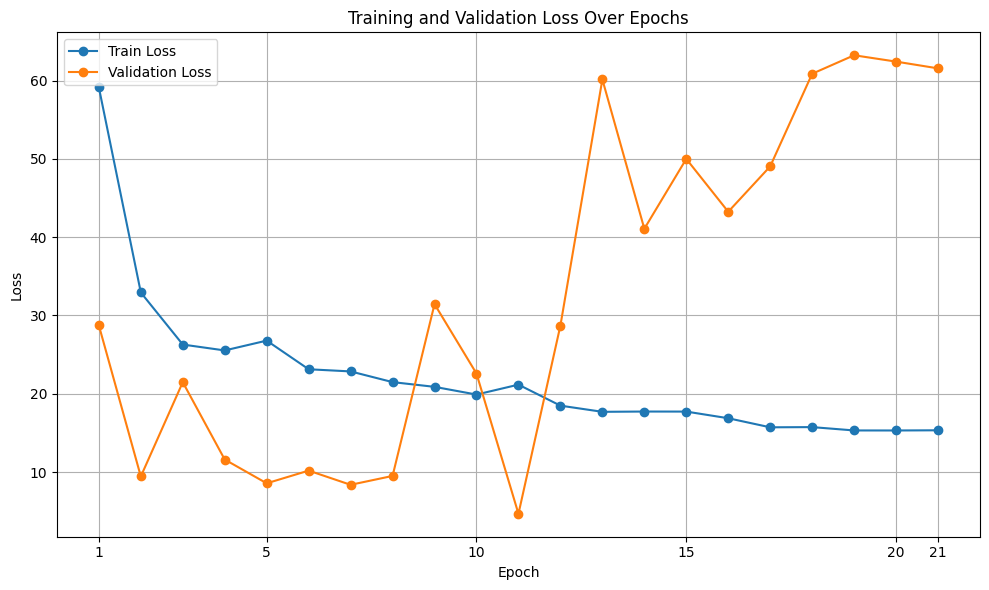

In [31]:
# Plot the training and validation loss history
plot_training_history(history, x_tick_interval=5)

# Model Evaluation

In [32]:
def evaluate_test_set(model, loader, device, mean_, std_, epsilon=1e-10):
    """
    Evaluate the model on the test set and return inverse-transformed predictions and truths.

    Parameters
    ----------
    model : nn.Module
        Trained model.
    loader : DataLoader
        Test data loader.
    device : torch.device
        Compute device.
    mean_ : float
        Training data mean for inverse scaling.
    std_ : float
        Training data std for inverse scaling.
    epsilon : float
        Small value to avoid division by zero.

    Returns
    -------
    test_preds_inv : np.ndarray
        Inverse-transformed predictions on the test set.
    test_trues_inv : np.ndarray
        Inverse-transformed true values on the test set.
    """
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for x, y, x_mark, y_mark in loader:
            x, y, x_mark, y_mark = x.to(device), y.to(device), x_mark.to(device), y_mark.to(device)
            out = model(x, x_mark)
            output_length = y.size(1)
            if out.size(1) != output_length:
                out = out[:, -output_length:, :]
            out = out.cpu().numpy()
            y = y.cpu().numpy()

            preds.append(out)
            trues.append(y)

    preds = np.concatenate(preds, axis=0).squeeze()
    trues = np.concatenate(trues, axis=0).squeeze()

    test_preds_inv = preds * (std_ + epsilon) + mean_
    test_trues_inv = trues * (std_ + epsilon) + mean_

    return test_preds_inv, test_trues_inv

In [33]:
# Get predictions
test_preds_inv, test_trues_inv = evaluate_test_set(model, test_loader, device, mean_, std_)

print(f"Length of test_preds_inv: {len(test_preds_inv)}")
print(f"Length of test_trues_inv: {len(test_trues_inv)}")

Length of test_preds_inv: 318
Length of test_trues_inv: 318


In [34]:
def compute_metrics(pred, true):
    """
    Compute a set of evaluation metrics for time series predictions.

    Parameters
    ----------
    pred : np.ndarray
        Predicted values.
    true : np.ndarray
        Actual values.

    Returns
    -------
    metrics_df : pd.DataFrame
        DataFrame containing MSE, RMSE, MAE, MAPE, sMAPE, MASE.
    """
    mse = np.mean((true - pred) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(true - pred))
    mape = np.mean(np.abs((true - pred) / (true + 1e-5))) * 100
    smape = 100 * np.mean(2.0 * np.abs(pred - true) / (np.abs(true) + np.abs(pred) + 1e-5))

    if len(true) > 1:
        naive_pred = true[:-1]
        naive_true = true[1:]
        mase_denom = np.mean(np.abs(naive_true - naive_pred)) if len(naive_true) > 0 else 1.0
    else:
        mase_denom = 1.0
    mase = np.mean(np.abs(true - pred)) / (mase_denom + 1e-5)

    metrics_df = pd.DataFrame({
        'Metric': ['MSE', 'RMSE', 'MAE', 'MAPE (%)', 'sMAPE (%)', 'MASE'],
        'Value': [mse, rmse, mae, mape, smape, mase]
    }).set_index('Metric')
    return metrics_df

In [35]:
# Create metrics DataFrame
metrics_df = compute_metrics(test_preds_inv, test_trues_inv)
print("Metrics on Test Set:")
display(metrics_df)

Metrics on Test Set:


,Value
Metric,
MSE,3191.944336
RMSE,56.497295
MAE,27.002974
MAPE (%),43.060058
sMAPE (%),43.925649
MASE,40.321806


In [36]:
def plot_test_predictions(test_preds_inv, test_trues_inv):
    """
    Plot actual vs. predicted values on the test set.

    Parameters
    ----------
    test_preds_inv : np.ndarray
        Inverse-transformed predictions.
    test_trues_inv : np.ndarray
        Inverse-transformed true values.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(test_trues_inv, label='Actual', color='blue')
    plt.plot(test_preds_inv, label='Predicted', color='red', linestyle='--')
    plt.title('Test Set: Actual vs. Predicted')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

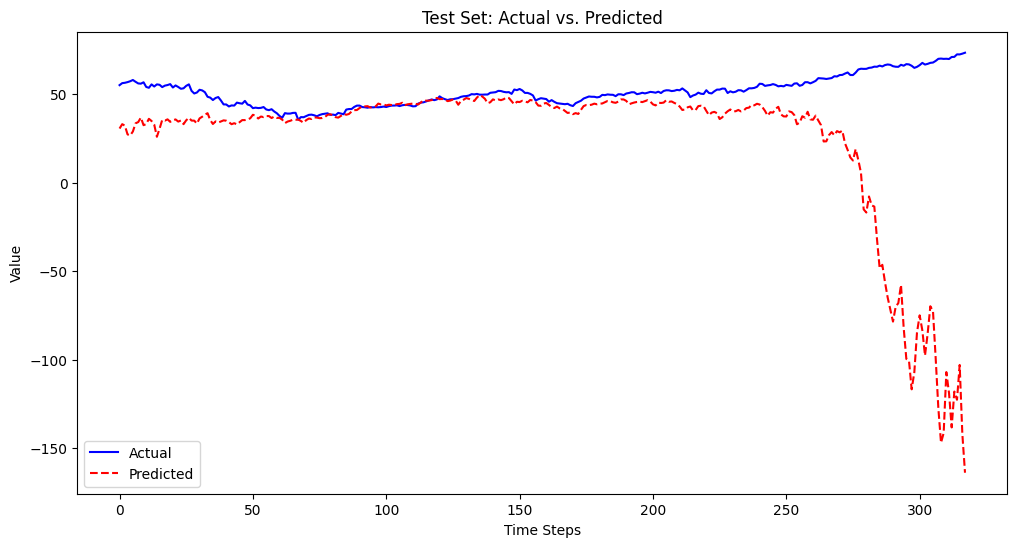

In [37]:
# Plot actual vs. predicted
plot_test_predictions(test_preds_inv, test_trues_inv)

# Model Tuning

In [38]:
def objective(trial):
    """
    Objective function for Optuna hyperparameter tuning with constraints.

    Parameters
    ----------
    trial : optuna.trial.Trial
        A single trial object that allows sampling hyperparameters.

    Returns
    -------
    float
        The minimum validation loss achieved during training.
    """
    # Define allowed (d_model, d_conv) pairs
    model_conv_pairs = []
    d_model_choices = [64, 128, 256, 512]
    d_conv_choices = [4, 16, 32, 64, 128]

    for d_model in d_model_choices:
        valid_d_conv = [conv for conv in d_conv_choices if conv <= d_model]
        for d_conv in valid_d_conv:
            model_conv_pairs.append((d_model, d_conv))

    # Suggest (d_model, d_conv) pair
    d_model_conv = trial.suggest_categorical("d_model_conv", model_conv_pairs)
    d_model, d_conv = d_model_conv

    # Define and suggest expand from allowed choices
    allowed_expand_choices = [2, 4]
    expand = trial.suggest_categorical("expand", allowed_expand_choices)

    # Suggest other hyperparameters
    d_ff = trial.suggest_categorical("d_ff", [8, 16, 32, 64, 128, 256])
    embed_type = trial.suggest_categorical("embed_type", ['fixed', 'learned'])
    dropout = trial.suggest_float("dropout", 0.0, 0.7)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    early_stopping_patience = trial.suggest_int("early_stopping_patience", 5, 100)
    max_lr_scheduler_patience = int(early_stopping_patience - 1)
    lr_scheduler_patience = trial.suggest_int("lr_scheduler_patience", 3, max_lr_scheduler_patience)
    lr_scheduler_factor = trial.suggest_float("lr_scheduler_factor", 0.05, 0.99)

    # Initialize model
    model = MambaModel(
        d_model=d_model,
        d_ff=d_ff,
        d_conv=d_conv,
        expand=expand,
        output_dim=1,
        embed_type=embed_type,
        dropout=dropout
    ).to(device)

    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    criterion = SMAPELoss()

    # Run training
    checkpoint_path = f"trial_{trial.number}_best_model.pth"

    try:
        model, history, best_epoch = run_training(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            epochs=100,
            early_stopping_patience=early_stopping_patience,
            lr_scheduler_patience=lr_scheduler_patience,
            lr_scheduler_factor=lr_scheduler_factor,
            print_progress=False,
            report_freq=1,
            checkpoint_path=checkpoint_path
        )
        val_loss = min(history['val_loss'])
        return val_loss, best_epoch

    except Exception as e:
        print(f"Trial {trial.number} failed: {e}")
        return float("inf"), 0

In [39]:
# Optuna study configuration
study = optuna.create_study(
    directions=["minimize", "maximize"],
    study_name="Mamba_Optimization_MultiObjective"
)
study.optimize(objective, n_trials=50, timeout=7200)

[I 2024-12-16 07:46:31,798] A new study created in memory with name: Mamba_Optimization_MultiObjective
[I 2024-12-16 07:47:36,735] Trial 0 finished with values: [3.6257825198609748, 20.0] and parameters: {'d_model_conv': (128, 64), 'expand': 2, 'd_ff': 256, 'embed_type': 'fixed', 'dropout': 0.18293371551041915, 'lr': 0.00027423713379200936, 'early_stopping_patience': 31, 'lr_scheduler_patience': 13, 'lr_scheduler_factor': 0.4442320741409389}.
[I 2024-12-16 07:48:58,055] Trial 1 finished with values: [200.0, 1.0] and parameters: {'d_model_conv': (512, 4), 'expand': 2, 'd_ff': 32, 'embed_type': 'fixed', 'dropout': 0.437146200728675, 'lr': 0.007562724009146433, 'early_stopping_patience': 79, 'lr_scheduler_patience': 48, 'lr_scheduler_factor': 0.9877871573725492}.
[I 2024-12-16 07:49:13,701] Trial 2 finished with values: [17.401546141326616, 12.0] and parameters: {'d_model_conv': (128, 64), 'expand': 4, 'd_ff': 16, 'embed_type': 'learned', 'dropout': 0.4421074950967377, 'lr': 0.00039921005

In [40]:
# Print the number of trials on the Pareto front
print(f"Number of trials on the Pareto front: {len(study.best_trials)}\n")

# Visualize the Pareto front
optuna.visualization.plot_pareto_front(study, target_names=["val_loss", "best_epoch"])

Number of trials on the Pareto front: 3



In [41]:
# Plot parameter importances for val_loss
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0], target_name="val_loss")

In [42]:
# Plot parameter importances for best_epoch
optuna.visualization.plot_param_importances(study, target=lambda t: t.values[1], target_name="best_epoch")

In [43]:
# Select the trial with the lowest validation loss
trial_with_lowest_val_loss = min(study.best_trials, key=lambda t: t.values[0])
print("Trial with lowest val_loss:")
print(f"\tnumber: {trial_with_lowest_val_loss.number}")
print(f"\tparams: {trial_with_lowest_val_loss.params}")
print(f"\tvalues: {trial_with_lowest_val_loss.values}")

Trial with lowest val_loss:
	number: 23
	params: {'d_model_conv': (256, 16), 'expand': 4, 'd_ff': 16, 'embed_type': 'fixed', 'dropout': 0.061433366815217126, 'lr': 0.00126543827998961, 'early_stopping_patience': 76, 'lr_scheduler_patience': 48, 'lr_scheduler_factor': 0.9316247454262079}
	values: [2.902436213538474, 47.0]


In [44]:
# Select the trial with the highest number of epochs
trial_with_highest_best_epoch = max(study.best_trials, key=lambda t: t.values[1])
print("Trial with highest best_epoch:")
print(f"\tnumber: {trial_with_highest_best_epoch.number}")
print(f"\tparams: {trial_with_highest_best_epoch.params}")
print(f"\tvalues: {trial_with_highest_best_epoch.values}")

Trial with highest best_epoch:
	number: 5
	params: {'d_model_conv': (64, 32), 'expand': 2, 'd_ff': 16, 'embed_type': 'fixed', 'dropout': 0.612312408147678, 'lr': 0.0018475911335953654, 'early_stopping_patience': 39, 'lr_scheduler_patience': 19, 'lr_scheduler_factor': 0.49819868716693755}
	values: [4.168118704004619, 99.0]


In [45]:
# Define a minimum threshold for number of epochs
MIN_EPOCHS = 5

# Filter Pareto front trials that meet the minimum epochs
balanced_trials = [t for t in study.best_trials if t.values[1] >= MIN_EPOCHS]

if balanced_trials:
    # Select the trial with the lowest val_loss among the balanced trials
    balanced_trial = min(balanced_trials, key=lambda t: t.values[0])
    print("Balanced Trial (Low val_loss & Sufficient Epochs):")
    print(f"\tnumber: {balanced_trial.number}")
    print(f"\tparams: {balanced_trial.params}")
    print(f"\tvalues: {balanced_trial.values}")
else:
    print("No trials met the epoch threshold. Consider lowering the MIN_EPOCHS or reviewing the Pareto front.")

Balanced Trial (Low val_loss & Sufficient Epochs):
	number: 23
	params: {'d_model_conv': (256, 16), 'expand': 4, 'd_ff': 16, 'embed_type': 'fixed', 'dropout': 0.061433366815217126, 'lr': 0.00126543827998961, 'early_stopping_patience': 76, 'lr_scheduler_patience': 48, 'lr_scheduler_factor': 0.9316247454262079}
	values: [2.902436213538474, 47.0]


In [46]:
# # Define a maximum threshold for val_loss
# MAX_VAL_LOSS = 5.5

# # Filter Pareto front trials that meet the val_loss threshold
# balanced_trials = [t for t in study.best_trials if t.values[0] <= MAX_VAL_LOSS]

# if balanced_trials:
#     # Select the trial with the highest number of epochs among the balanced trials
#     balanced_trial = max(balanced_trials, key=lambda t: t.values[1])
#     print("Balanced Trial (Low val_loss & High Number of Epochs):")
#     print(f"\tnumber: {balanced_trial.number}")
#     print(f"\tparams: {balanced_trial.params}")
#     print(f"\tvalues: {balanced_trial.values}\n")
# else:
#     print("No trials met the val_loss threshold. Consider increasing the MAX_VAL_LOSS or reviewing the Pareto front.")

In [47]:
# Retrieve the best hyperparameters from the balanced trial
best_params = balanced_trial.params.copy()

# Unpack the composite parameter 'd_model_conv'
d_model_conv = best_params.pop("d_model_conv")  # Remove 'd_model_conv' from the params
best_d_model, best_d_conv = d_model_conv  # Unpack into 'd_model' and 'd_conv'

In [48]:
# Extract other hyperparameters
best_expand = best_params["expand"]
best_d_ff = best_params["d_ff"]
best_embed_type = best_params["embed_type"]
best_dropout = best_params["dropout"]
best_lr = best_params["lr"]
best_early_stopping_patience = best_params["early_stopping_patience"]
best_lr_scheduler_patience = best_params["lr_scheduler_patience"]
best_lr_scheduler_factor = best_params["lr_scheduler_factor"]

In [49]:
# Initialize the model with the best hyperparameters
final_model = MambaModel(
    d_model=best_d_model,
    d_ff=best_d_ff,
    d_conv=best_d_conv,
    expand=best_expand,
    embed_type=best_embed_type,
    dropout=best_dropout,
    output_dim=1
).to(device)

In [50]:
# Initialize optimizer and loss function
optimizer = torch.optim.AdamW(final_model.parameters(), lr=best_lr)
criterion = SMAPELoss()

checkpoint_path = "best_model_final.pth"  # Save the final best model
print("Starting training with the best hyperparameters...\n")

# Train the final model
final_model, final_history, final_best_epoch = run_training(
    model=final_model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    epochs=100,
    early_stopping_patience=best_early_stopping_patience,
    lr_scheduler_patience=best_lr_scheduler_patience,
    lr_scheduler_factor=best_lr_scheduler_factor,
    print_progress=True,
    report_freq=1,
    checkpoint_path=checkpoint_path
)

Starting training with the best hyperparameters...

Epoch 1/100 - Train Loss: 191.7550 | Val Loss: 200.0000 | Time: 0.81s | LR: 1.27e-03
Epoch 2/100 - Train Loss: 147.7165 | Val Loss: 200.0000 | Time: 0.69s | LR: 1.27e-03
Epoch 3/100 - Train Loss: 58.2705 | Val Loss: 47.3113 | Time: 0.69s | LR: 1.27e-03
Epoch 4/100 - Train Loss: 30.2716 | Val Loss: 44.3721 | Time: 0.69s | LR: 1.27e-03
Epoch 5/100 - Train Loss: 22.2434 | Val Loss: 52.1339 | Time: 0.69s | LR: 1.27e-03
Epoch 6/100 - Train Loss: 23.8960 | Val Loss: 48.0303 | Time: 0.69s | LR: 1.27e-03
Epoch 7/100 - Train Loss: 20.0707 | Val Loss: 115.5270 | Time: 0.69s | LR: 1.27e-03
Epoch 8/100 - Train Loss: 18.3124 | Val Loss: 17.1477 | Time: 0.69s | LR: 1.27e-03
Epoch 9/100 - Train Loss: 18.0001 | Val Loss: 49.9107 | Time: 0.69s | LR: 1.27e-03
Epoch 10/100 - Train Loss: 18.8436 | Val Loss: 39.8311 | Time: 0.70s | LR: 1.27e-03
Epoch 11/100 - Train Loss: 18.8128 | Val Loss: 73.0001 | Time: 0.70s | LR: 1.27e-03
Epoch 12/100 - Train Loss: 2

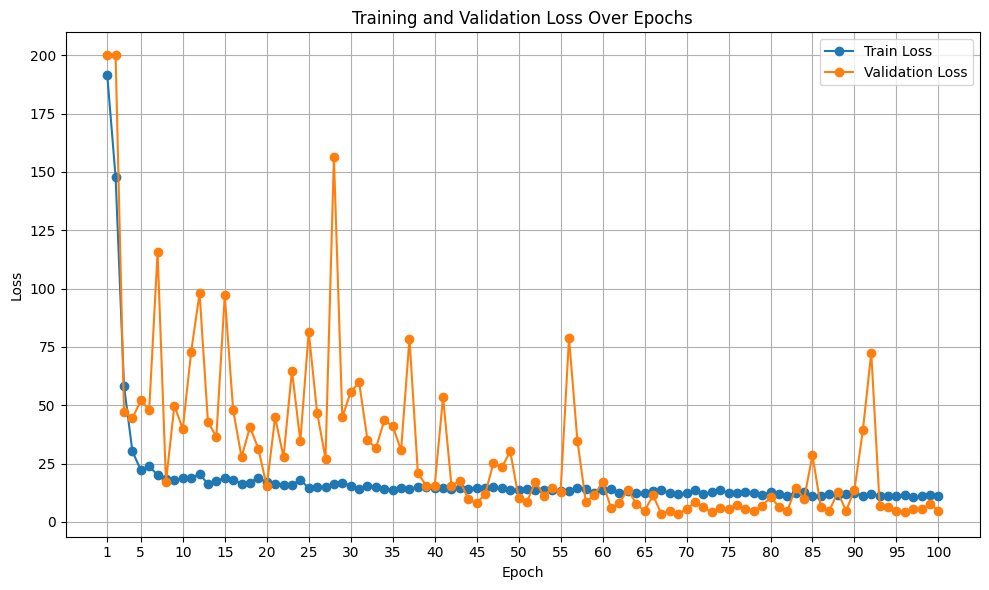

In [51]:
# Plot the training and validation loss history
plot_training_history(final_history, x_tick_interval=5)

# Model Re-Evaluation

In [52]:
# Get predictions
final_test_preds_inv, test_trues_inv = evaluate_test_set(final_model, test_loader, device, mean_, std_)

print(f"Length of final_test_preds_inv: {len(final_test_preds_inv)}")
print(f"Length of test_trues_inv: {len(test_trues_inv)}")

Length of final_test_preds_inv: 318
Length of test_trues_inv: 318


In [53]:
# Create metrics DataFrame
final_metrics_df = compute_metrics(final_test_preds_inv, test_trues_inv)
print("Metrics on Test Set:")
display(final_metrics_df)

Metrics on Test Set:


,Value
Metric,
MSE,2.060799e+06
RMSE,1.435548e+03
MAE,3.962244e+02
MAPE (%),5.731173e+02
sMAPE (%),3.216668e+01
MASE,5.916564e+02


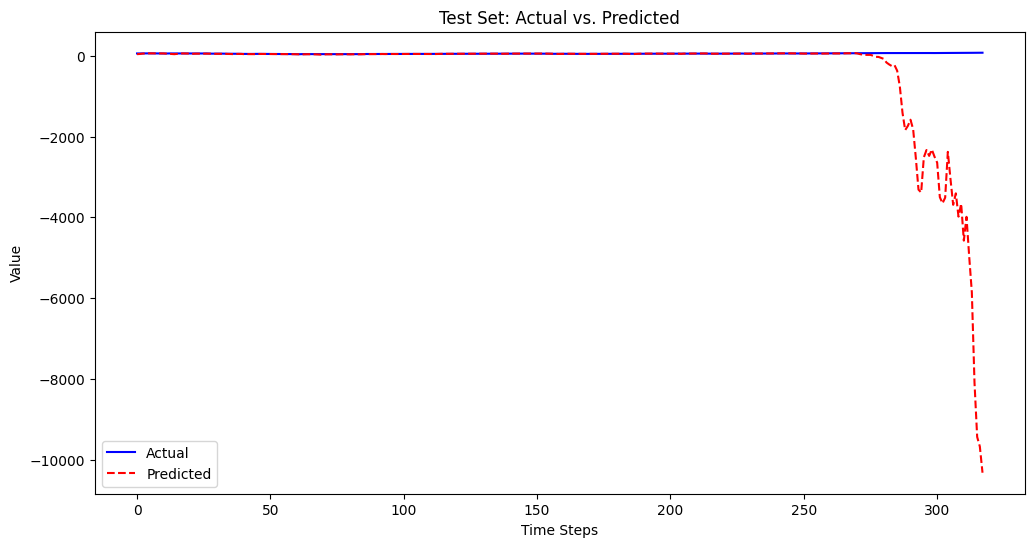

In [54]:
# Plot actual vs. predicted
plot_test_predictions(final_test_preds_inv, test_trues_inv)

# Results Comparison

In [55]:
# Add a column to each DataFrame to indicate the model
metrics_df['Model'] = 'Untuned'
final_metrics_df['Model'] = 'Tuned'

# Combine the two DataFrames
metrics_combined = pd.concat([metrics_df, final_metrics_df], axis=0).reset_index()

# Pivot the table to display the comparison
metrics_pivot = metrics_combined.pivot(index='Metric', columns='Model', values='Value')
print("\nMetrics Comparison:")
display(metrics_pivot)


Metrics Comparison:


Model,Tuned,Untuned
Metric,,
MAE,3.962244e+02,27.002974
MAPE (%),5.731173e+02,43.060058
MASE,5.916564e+02,40.321806
MSE,2.060799e+06,3191.944336
RMSE,1.435548e+03,56.497295
sMAPE (%),3.216668e+01,43.925649


In [56]:
def plot_side_by_side(actual, preds_untuned, preds_tuned):
    """
    Plot actual vs. predicted values for untuned and tuned models side by side.

    Parameters
    ----------
    actual : np.ndarray
        True values of the test set.
    preds_untuned : np.ndarray
        Predictions from the untuned model.
    preds_tuned : np.ndarray
        Predictions from the tuned model.
    """
    plt.figure(figsize=(14, 6))

    # Subplot for the untuned model
    plt.subplot(1, 2, 1)
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(preds_untuned, label='Untuned Predictions', color='red', linestyle='--')
    plt.title('Untuned Model Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()

    # Subplot for the tuned model
    plt.subplot(1, 2, 2)
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(preds_tuned, label='Tuned Predictions', color='green', linestyle='--')
    plt.title('Tuned Model Predictions')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

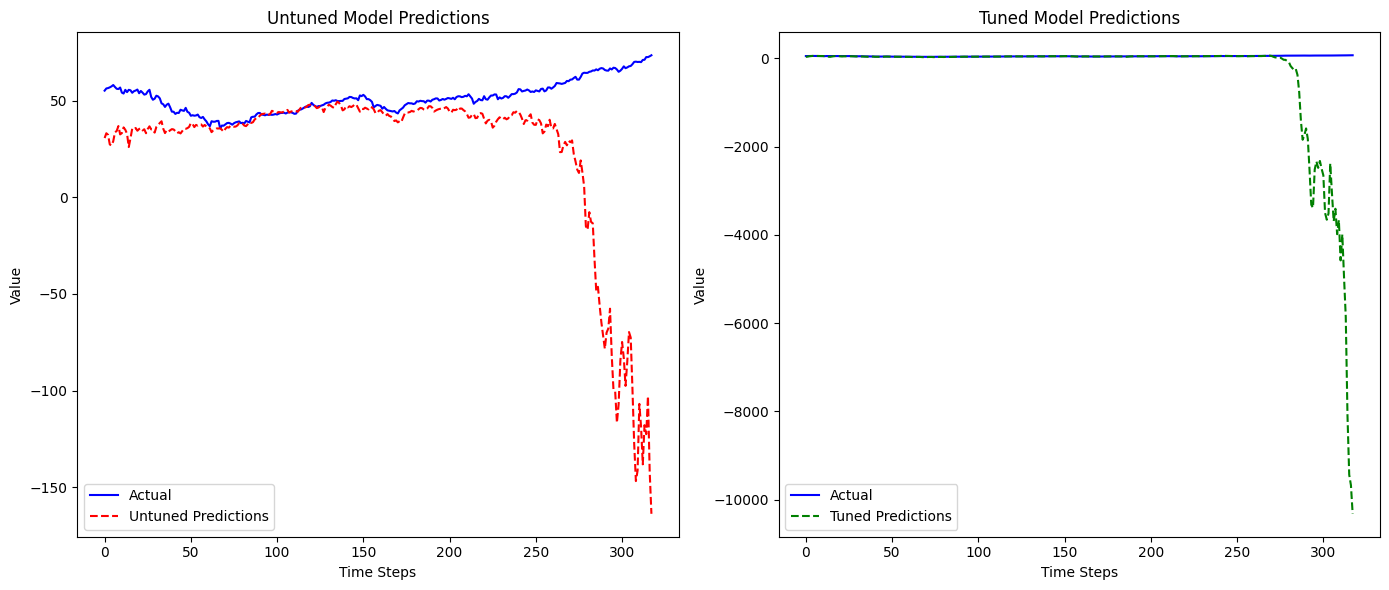

In [57]:
# Plot comparison
plot_side_by_side(
    actual=test_trues_inv,
    preds_untuned=test_preds_inv,
    preds_tuned=final_test_preds_inv
)